# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [170]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import (accuracy_score, mean_absolute_error, recall_score, 
                             precision_score, f1_score, roc_curve, roc_auc_score, make_scorer)

from sklearn import set_config
set_config(display='diagram')
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.dummy import DummyRegressor

import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.utils import shuffle
plt.rcParams['figure.dpi'] = 140
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer


plt.rcParams["font.family"] = "Times New Roman"
RANDOM_STATE=12345

In [2]:
pth1 = '/datasets/'
pth2 = 'C:/Users/Солнышко/Documents/'
pth3 = 'C:/Users/Home/Documents/Яндекс/Сатанист/'

if os.path.exists(pth1):
    df = pd.read_csv(pth1 + 'Churn.csv')
elif os.path.exists(pth2):
    df = pd.read_csv(pth2 + 'Churn.csv')
elif os.path.exists(pth3):
    df = pd.read_csv(pth3 + 'Churn.csv')
else:
    print('Something is wrong')

In [3]:
# сбор данных о датафрейме:
def data_info(data):
    print(f'''
    ----------------------------------------
    Первые строки датафрейма:
    ----------------------------------------''')
    display(data.head())
    print(f'''
    ----------------------------------------
    Последние строки датафрейма:
    ----------------------------------------''')
    display(data.tail())
    print(f'''
    ----------------------------------------
    Общая информация:
    ----------------------------------------''')
    print(data.info())
    print(f'''
    ----------------------------------------
    Дупликаты:
    ----------------------------------------''')
    print(data.duplicated().sum())
    print(f'''
    ----------------------------------------
    Пропуски:
    ----------------------------------------''')
    display(round(data.isna().sum(),))
    print(f'''
    ----------------------------------------
    И немного статистических данных:
    ----------------------------------------''')
    print(data.describe(include='all'))      
    
def get_roc_curve(y, y_pred):
    '''функция для подсчёта AUC и отрисовки ROC-кривой'''
    fpr, tpr, thresholds = roc_curve(y, y_pred)
    # Вычисляем AUC
    auc = roc_auc_score(y, y_pred)
    # Строим ROC-кривую
    plt.figure(figsize=(11, 5))
    plt.plot(fpr, tpr, c='orange', label=f'AUC={auc:.3f}')
    plt.plot([0, 1], [0, 1], '--', color='#2C3E50')
    plt.xlabel('FPR - False Positive Rate')
    plt.ylabel('TPR - True Positive Rate')
    plt.title('ROC-кривая', fontweight='bold', fontsize=15,  fontname='Arial')
    plt.legend()
    plt.grid(linewidth=0.25, linestyle='--')
    plt.show()

In [4]:
data_info(df)


    ----------------------------------------
    Первые строки датафрейма:
    ----------------------------------------


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0



    ----------------------------------------
    Последние строки датафрейма:
    ----------------------------------------


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1
9999,10000,15628319,Walker,792,France,Female,28,NaN,130142.79,1,1,0,38190.78,0



    ----------------------------------------
    Общая информация:
    ----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
mem

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64


    ----------------------------------------
    И немного статистических данных:
    ----------------------------------------
          RowNumber    CustomerId Surname   CreditScore Geography Gender  \
count   10000.00000  1.000000e+04   10000  10000.000000     10000  10000   
unique          NaN           NaN    2932           NaN         3      2   
top             NaN           NaN   Smith           NaN    France   Male   
freq            NaN           NaN      32           NaN      5014   5457   
mean     5000.50000  1.569094e+07     NaN    650.528800       NaN    NaN   
std      2886.89568  7.193619e+04     NaN     96.653299       NaN    NaN   
min         1.00000  1.556570e+07     NaN    350.000000       NaN    NaN   
25%      2500.75000  1.562853e+07     NaN    584.000000       NaN    NaN   
50%      5000.50000  1.569074e+07     NaN    652.000000       NaN    NaN   
75%      7500.25000  1.575323e+07     NaN    718.000000       NaN    NaN   
max     10000.00000  1.581569e+07   

У нас всего есть 14 колонок:
- RowNumber (индекс строки)
- CustomerId (id покупателя)
- Surname (фамилия)
- CreditScore (кредитный )
- Geography (местоположение)
- Gender (пол)
- Age (возраст)
- Tenure (сколько лет человек является клиентом банка)
- Balance (баланс на дату выгрузки данных)
- NumOfProducts (количество используемых продуктов)
- HasCrCard (наличие кредитной карты)
- IsActiveMember (является ли активным пользователем)
- EstimatedSalary (предполагаемая зарплата)
- Exited (факт ухода клиента) - `нам необходимо предсказать`

Дупликатов нет, следовательно, некоторые колонки можно удалить:

- RowNumber - обозначение строки, можно удалить
- CustomerId - идентификационный номер пользователя, также можно удалить,
- Surname - фамилия, аналогично можно удалить,

так как эти колонки используются для более легкого понимания человеческому взгляду, в отличие от остальных.

Также мы видим, что необходимо обработать несколько колонок в технике *OHE* - Geography and Gender.

Критических выбросов в данных не наблюдается, однако есть непонятного происхождения пропуски в колонке `Tenure`.

In [5]:
columns = ['RowNumber', 'CustomerId','Surname']
data = df.drop(columns, axis=1)

In [6]:
data[data['Tenure'].isna()]

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
30,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
...,...,...,...,...,...,...,...,...,...,...,...
9944,744,Germany,Male,41,NaN,190409.34,2,1,1,138361.48,0
9956,520,France,Female,46,NaN,85216.61,1,1,0,117369.52,1
9964,479,France,Male,34,NaN,117593.48,2,0,0,113308.29,0
9985,659,France,Male,36,NaN,123841.49,2,1,0,96833.00,0


In [7]:
(data[data['Tenure'].isna()].shape[0]/data.shape[0])*100

9.09

Пропуски наблюдаются только в одной колонке, которая описывает продолжительность пользования клиентом услугами банка.

Есть несколько вариантов действий:

- Удалить пропуски - *однако их около 10%*
- Заполнить каким-либо значением

Мы остановимся на втором варианте, заполнять будем с помощью IterativeImputer, так как просто опускать практически 10% данных - не целесообразно

In [8]:
imputer = IterativeImputer(max_iter=20, verbose=2)


data['Tenure'] = np.round(imputer.fit_transform(data[['Tenure']]))

In [9]:
data.columns = data.columns.str.lower()

In [10]:
data.groupby('exited').count()['age']

exited
0    7963
1    2037
Name: age, dtype: int64

Выборка, как и предполагалось, практически в 4 раза "перевешивает" в сторону остающихся верными банку клиентов => необходимо доработать данные

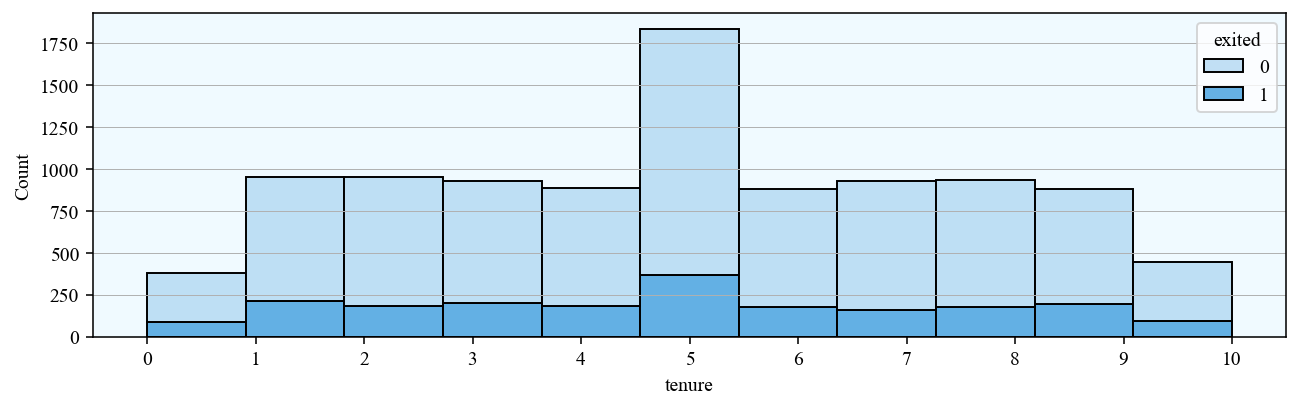

In [11]:
fig = plt.figure(figsize=(11, 3))
ax = fig.add_subplot()
sns.histplot(df, x=data.tenure, hue=data.exited, multiple='stack', bins=11,
            palette=['#AED6F1', '#3498DB'])
ax.set_xticks(range(11))
ax.set_facecolor('#f0faff')
ax.grid(axis='y', linewidth=0.5)
plt.show()

Наглядно видно, что *имеется* ***дисбаланс классов*** - с этим нужно будет поработать.

**В ходе первого шага** - подготовки данных - мы проверили данные на пропуски, выбросы, удалили колонки, не нужные для дальнейшего исследования, а также обработали категориальные признаки (*ohe*), масштабировали и разделили данные на 3 выборки.

## Исследование задачи

Разобьем данные:

In [13]:
cat_col = ['geography','gender']
num_col = ['creditscore','age','tenure','balance','numofproducts','hascrcard','isactivemember','estimatedsalary']
features = data[cat_col+num_col]
target = data['exited']

features_train, features_tmp, target_train, target_tmp = train_test_split(features, target, test_size=0.4,
                                                                         random_state=RANDOM_STATE, stratify=target)

features_valid, features_test, target_valid, target_test = train_test_split(features_tmp, target_tmp, test_size=0.5,
                                                                           random_state=RANDOM_STATE, stratify=target_tmp)

Сделаем пайплайн для более эффективной и правильной обработки данных:

In [385]:
def return_best_model(model, params, features_train, target_train, features_valid=False, target_valid=False):
    num_pipeline = Pipeline(steps=[('scale', StandardScaler())])
    cat_pipeline = Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                               ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse=False, drop='first'))])

    col_trans = ColumnTransformer(transformers=[('num_pipeline', num_pipeline, num_col),
                                            ('cat_pipeline', cat_pipeline, cat_col)], remainder='drop', n_jobs=-1)
    skf = StratifiedKFold(n_splits=5,  shuffle=True, random_state=42)
    clf = model

    model_pipeline = Pipeline(steps=[('preprocess',col_trans),
                                     ('clf', clf)])
    score = make_scorer(f1_score, greater_is_better = True) # вводим свою метрику для кросс-валидации
    
    grid_search = GridSearchCV(model_pipeline, param_grid = params, cv=skf, scoring = score)
    grid_search.fit(features_train, target_train)
    
    if features_valid is not False and target_valid is not False:
        metrics = []
        metrics.append(precision_score(target_valid, grid_search.predict(features_valid)))
        metrics.append(recall_score(target_valid, grid_search.predict(features_valid)))
        metrics.append(f1_score(target_valid, grid_search.predict(features_valid)))
        metrics.append(roc_auc_score(target_valid, grid_search.predict_proba(features_valid)[:,1]))
        return grid_search, metrics
        
    return grid_search

def print_valid_model(model,features, target):
    print(f'''------------------------------
Лучшиe train гиперпараметры:
{model.best_params_}
------------------------------
Лучшая train метрика: 
{model.best_score_}
------------------------------
Метрики на valid:
precision: {precision_score(target, model.predict(features))}; 
recall: {recall_score(target, model.predict(features))};
f1: {f1_score(target, model.predict(features))}
roc-auc: {roc_auc_score(target, model.predict_proba(features)[:,1])}
------------------------------''')
    
# функция для вычисления fpr,tpr, thresholds, AUC_ROC и построения графика
def ftt(model, features, target):
    probabilities = model.predict_proba(features)
    fpr, tpr, thresholds = roc_curve(target, probabilities[:,1])
    auc_roc = roc_auc_score(target, probabilities[:,1])
    print(f'AUC-ROC: {auc_roc}')
    plt.figure(figsize=(5,5), dpi=200)
    sns.set()
    plt.plot(fpr, tpr, color='darkblue')
    plt.plot([0, 1], [0, 1], linestyle='--', color='orange', alpha=0.8)
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.xlabel('False Positive Rate', fontfamily='monospace')
    plt.ylabel('True Positive Rate', fontfamily='monospace')
    plt.title("ROC-кривая")
    plt.show()

Проверим 5 моделей на несбалансированной выборке:

- DecisionTreeClassifier
- RandomForestClassifier
- LogisticRegression
- KNeighborsClassifier
- GradientBoostingClassifier

Будем сразу искать лучшую модель на `train`, а потом проверять на `valid`:

In [370]:
params_dtc = {
        'clf__splitter': ['best', 'random'], 
        'clf__max_depth': range(1,100, 4), 
        'clf__criterion':['gini', 'entropy', 'log_loss']}
model = DecisionTreeClassifier(random_state=RANDOM_STATE)
model_dtc, metrics = return_best_model(model, params_dtc, features_train, target_train, features_valid, target_valid)
metrics

[0.7440273037542662,
 0.5343137254901961,
 0.6219686162624822,
 0.8706807628830429]

Как раз таки метрики он вывел на валидационные данные, так что занесем в результирующую таблицу:

In [353]:
res = pd.DataFrame(columns=['precision','recall','f1','roc-auc'])
res.loc['dtc'] = metrics

print_valid_model(model_dtc, features_valid, target_valid)

------------------------------
Лучшиe train гиперпараметры:
{'clf__criterion': 'entropy', 'clf__max_depth': 9, 'clf__splitter': 'best'}
------------------------------
Лучшая train метрика: 
0.5628794688010614
------------------------------
Метрики на valid:
precision: 0.7440273037542662; 
recall: 0.5343137254901961;
f1: 0.6219686162624822
roc-auc: 0.8706807628830429
------------------------------


In [354]:
params_rfc = {
        'clf__n_estimators':[10, 50, 100],
        'clf__criterion': ['gini', 'entropy', 'log_loss'],
        'clf__max_leaf_nodes':[None,2,5,10,20,50], 
        'clf__max_depth': [10, 50, 100], 
        'clf__max_features': ['sqrt','log2', None]}

model = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
model_rfc, metrics = return_best_model(model, params_rfc, features_train, target_train, features_valid, target_valid)

res.loc['rfc'] = metrics

print_valid_model(model_rfc, features_valid, target_valid)

------------------------------
Лучшиe train гиперпараметры:
{'clf__criterion': 'gini', 'clf__max_depth': 50, 'clf__max_features': None, 'clf__max_leaf_nodes': 50, 'clf__n_estimators': 100}
------------------------------
Лучшая train метрика: 
0.5853362858751868
------------------------------
Метрики на valid:
precision: 0.7717391304347826; 
recall: 0.5220588235294118;
f1: 0.6228070175438597
roc-auc: 0.8798103569317174
------------------------------


In [355]:
params_lr = {
        'clf__penalty':['l1', 'l2', 'elasticnet', None],
        'clf__C':[0.1, 1, 10],
        'clf__solver':['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
        'clf__max_iter':[50, 100, 500]}


model = LogisticRegression(random_state=RANDOM_STATE)
model_lr, metrics = return_best_model(model, params_lr, features_train, target_train, features_valid, target_valid)

res.loc['lr'] = metrics

print_valid_model(model_lr, features_valid, target_valid)

------------------------------
Лучшиe train гиперпараметры:
{'clf__C': 0.1, 'clf__max_iter': 50, 'clf__penalty': None, 'clf__solver': 'lbfgs'}
------------------------------
Лучшая train метрика: 
0.31364208064358046
------------------------------
Метрики на valid:
precision: 0.5957446808510638; 
recall: 0.20588235294117646;
f1: 0.30601092896174864
roc-auc: 0.7885352005123657
------------------------------


In [356]:
params_knn = {
        'clf__n_neighbors': [5, 10, 15, 50],
        'clf__weights':['uniform', 'distance'],
        'clf__algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']}

model = KNeighborsClassifier(n_jobs=1)
model_knn, metrics = return_best_model(model, params_knn, features_train, target_train, features_valid, target_valid)

res.loc['knn'] = metrics

print_valid_model(model_knn, features_valid, target_valid)

------------------------------
Лучшиe train гиперпараметры:
{'clf__algorithm': 'auto', 'clf__n_neighbors': 5, 'clf__weights': 'distance'}
------------------------------
Лучшая train метрика: 
0.5019661640756439
------------------------------
Метрики на valid:
precision: 0.8181818181818182; 
recall: 0.6397058823529411;
f1: 0.7180192572214581
roc-auc: 0.8918019940388215
------------------------------


In [357]:
params_gbc = {
        'clf__learning_rate':[0.01, 0.1],
        'clf__n_estimators':[10, 50, 100],
        'clf__max_depth':[3, 10, 25]}

model = GradientBoostingClassifier(random_state=RANDOM_STATE)
model_gbc, metrics = return_best_model(model, params_gbc, features_train, target_train, features_valid, target_valid)

res.loc['gbc'] = metrics

print_valid_model(model_gbc, features_valid, target_valid)

------------------------------
Лучшиe train гиперпараметры:
{'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__n_estimators': 100}
------------------------------
Лучшая train метрика: 
0.579527273471504
------------------------------
Метрики на valid:
precision: 0.774074074074074; 
recall: 0.5122549019607843;
f1: 0.6165191740412979
roc-auc: 0.8879130640949847
------------------------------


In [358]:
res.sort_values('f1', ascending=False)

,precision,recall,f1,roc-auc
knn,0.818182,0.639706,0.718019,0.891802
dtc,0.771739,0.522059,0.622807,0.879810
rfc,0.771739,0.522059,0.622807,0.879810
gbc,0.774074,0.512255,0.616519,0.887913
lr,0.595745,0.205882,0.306011,0.788535


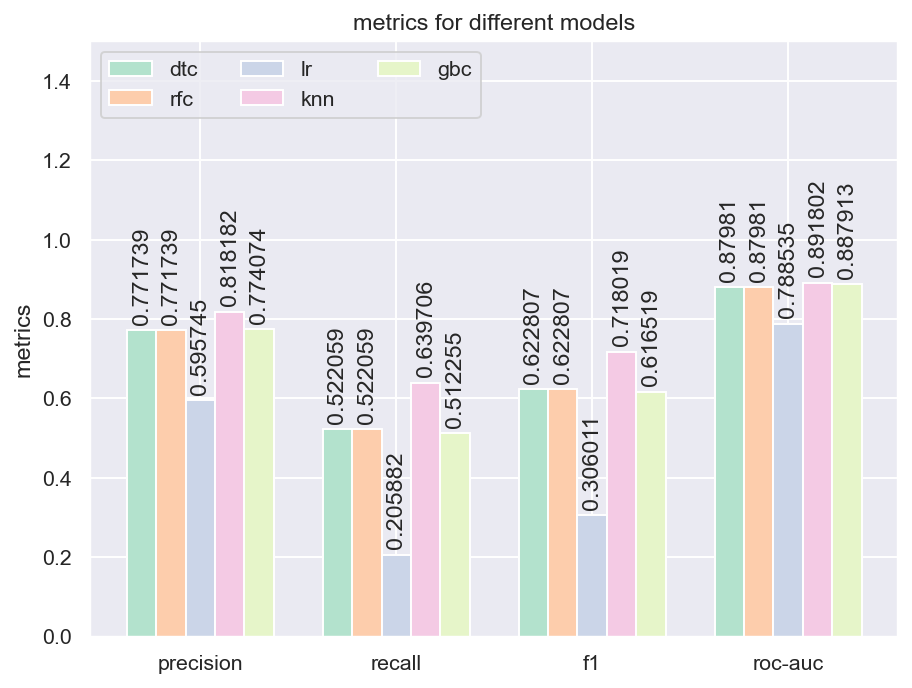

In [360]:
cmap = sns.color_palette("Pastel2")
metrics = ('precision','recall','f1','roc-auc')
models = {
    'dtc': tuple(res.values[0]),
    'rfc': tuple(res.values[1]),
    'lr': tuple(res.values[2]),
    'knn': tuple(res.values[3]),
    'gbc': tuple(res.values[4])
}

x = np.arange(len(metrics))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in models.items():
    sns.color_palette("Pastel2")
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, color=cmap[multiplier])
    ax.bar_label(rects, padding=3, rotation=90)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('metrics')
ax.set_title('metrics for different models')
ax.set_xticks(x + width*2, metrics)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 1.5)

plt.show()

Как мы видим, все модели, кроме логистической регрессии отработали неплохо, однако, думаю, можно еще лучше - для этого попробуем побороться с дисбалансом классов. 
KNN на уровень выше всех моделей, однако roc-auc у всех держится примерно на одном уровне - а значит, все модели достаточно определяют разные классы.

## Борьба с дисбалансом

Для борьбы с дисбалансом классов, применим технику *upsampling* и *downsampling*:

In [361]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    # соединим в нужном количестве
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    # перемешаем
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    #  возвращаем нужное значение
    return features_upsampled, target_upsampled

def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled



features_train_downsampled, target_train_downsampled = downsample(features_train, target_train, 0.25)

features_train_upsampled, target_train_upsampled = upsample(features_train, target_train, 4)

In [362]:
target_train_downsampled.value_counts(normalize=1)

1    0.505793
0    0.494207
Name: exited, dtype: float64

In [363]:
target_train_upsampled.value_counts(normalize=1)

1    0.505793
0    0.494207
Name: exited, dtype: float64

Для начала, посмотрим какой из методов будет лучше, через подбор параметров достаточно "простой" для вычисления модели (*randomforest тут умрет*):

In [364]:
params_dtc = {
        'clf__splitter': ['best', 'random'], 
        'clf__max_depth': range(1,100, 4), 
        'clf__criterion':['gini', 'entropy', 'log_loss']}

model = DecisionTreeClassifier(random_state=RANDOM_STATE)

model_dtcup = return_best_model(model, params_dtc, features_train_upsampled, target_train_upsampled)

print_valid_model(model_dtcup, features_valid, target_valid)

------------------------------
Лучшиe train гиперпараметры:
{'clf__criterion': 'gini', 'clf__max_depth': 29, 'clf__splitter': 'random'}
------------------------------
Лучшая train метрика: 
0.9307416262553618
------------------------------
Метрики на valid:
precision: 0.6980676328502415; 
recall: 0.7083333333333334;
f1: 0.7031630170316302
roc-auc: 0.8149078726968174
------------------------------


In [365]:
params_dtc = {
        'clf__splitter': ['best', 'random'], 
        'clf__max_depth': range(1,100, 4), 
        'clf__criterion':['gini', 'entropy', 'log_loss']}

model = DecisionTreeClassifier(random_state=RANDOM_STATE)

model_dtcdown = return_best_model(model, params_dtc, features_train_downsampled, target_train_downsampled)

print_valid_model(model_dtcdown, features_valid, target_valid)

------------------------------
Лучшиe train гиперпараметры:
{'clf__criterion': 'gini', 'clf__max_depth': 5, 'clf__splitter': 'best'}
------------------------------
Лучшая train метрика: 
0.7674433163867354
------------------------------
Метрики на valid:
precision: 0.43112244897959184; 
recall: 0.8284313725490197;
f1: 0.5671140939597316
roc-auc: 0.8447191533648636
------------------------------


С `upsampling` у нас возросла полнота нашей модели, но при этом немного упала точность - но на общий взгляд - `f1` тоже увеличилась.

С `downsampling` у нас упали практически все показатели (кроме `roc-auc`) - это и не мудрено - *данные на вес золота* - чем их больше в обучении, тем лучше.

Учитывая характеристики, будем применять *`upsample`*

In [367]:
resup = pd.DataFrame(index = ['dtc','rfc','lr','knn','gbc'], columns=['precision','recall','f1','roc-auc'])

In [371]:
model = DecisionTreeClassifier(random_state=RANDOM_STATE)

model_dtcup, metrics = return_best_model(model, params_dtc, features_train_upsampled, target_train_upsampled,
                             features_valid, target_valid)

resup.loc['dtc'] = metrics

In [372]:
model = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
model_rfcup, metrics = return_best_model(model, params_rfc, features_train_upsampled, target_train_upsampled, 
                                         features_valid, target_valid)

resup.loc['rfc'] = metrics

print_valid_model(model_rfcup, features_valid, target_valid)

------------------------------
Лучшиe train гиперпараметры:
{'clf__criterion': 'gini', 'clf__max_depth': 50, 'clf__max_features': 'sqrt', 'clf__max_leaf_nodes': None, 'clf__n_estimators': 50}
------------------------------
Лучшая train метрика: 
0.9580880223091434
------------------------------
Метрики на valid:
precision: 0.8076923076923077; 
recall: 0.7205882352941176;
f1: 0.761658031088083
roc-auc: 0.9366593999408808
------------------------------


In [373]:
model = LogisticRegression(random_state=RANDOM_STATE)

model_lrup, metrics = return_best_model(model, params_lr, features_train_upsampled, target_train_upsampled,
                             features_valid, target_valid)

resup.loc['lr'] = metrics
print_valid_model(model_lrup, features_valid, target_valid)

------------------------------
Лучшиe train гиперпараметры:
{'clf__C': 0.1, 'clf__max_iter': 50, 'clf__penalty': 'l1', 'clf__solver': 'saga'}
------------------------------
Лучшая train метрика: 
0.6982417773623957
------------------------------
Метрики на valid:
precision: 0.4005305039787798; 
recall: 0.7401960784313726;
f1: 0.5197934595524957
roc-auc: 0.7949089811804119
------------------------------


In [374]:
model = KNeighborsClassifier(n_jobs=1)

model_knnup, metrics = return_best_model(model, params_knn, features_train_upsampled, target_train_upsampled,
                             features_valid, target_valid)

resup.loc['knn'] = metrics
print_valid_model(model_knnup, features_valid, target_valid)

------------------------------
Лучшиe train гиперпараметры:
{'clf__algorithm': 'auto', 'clf__n_neighbors': 50, 'clf__weights': 'distance'}
------------------------------
Лучшая train метрика: 
0.9040701396603579
------------------------------
Метрики на valid:
precision: 0.6105072463768116; 
recall: 0.8259803921568627;
f1: 0.7020833333333333
roc-auc: 0.9344008646172037
------------------------------


In [376]:
model = GradientBoostingClassifier(random_state=RANDOM_STATE)

model_gbcup, metrics = return_best_model(model, params_gbc, features_train_upsampled, target_train_upsampled,
                             features_valid, target_valid)

resup.loc['gbc'] = metrics
print_valid_model(model_gbcup, features_valid, target_valid)

------------------------------
Лучшиe train гиперпараметры:
{'clf__learning_rate': 0.1, 'clf__max_depth': 10, 'clf__n_estimators': 100}
------------------------------
Лучшая train метрика: 
0.9554802387894693
------------------------------
Метрики на valid:
precision: 0.7936507936507936; 
recall: 0.7352941176470589;
f1: 0.7633587786259542
roc-auc: 0.9191207261799192
------------------------------


In [378]:
resup.sort_values('f1',ascending=False)

,precision,recall,f1,roc-auc
gbc,0.793651,0.735294,0.763359,0.919121
rfc,0.807692,0.720588,0.761658,0.936659
dtc,0.698068,0.708333,0.703163,0.814908
knn,0.610507,0.82598,0.702083,0.934401
lr,0.400531,0.740196,0.519793,0.794909


Здесь лучше всего себя показала модель градиентного бустинга - ее мы и будем проверять на тестовых данных. Остальные модели показали примерно соотносимое качество - у всех выросла и точность, и полнота, по сравнению с необработанными данными.

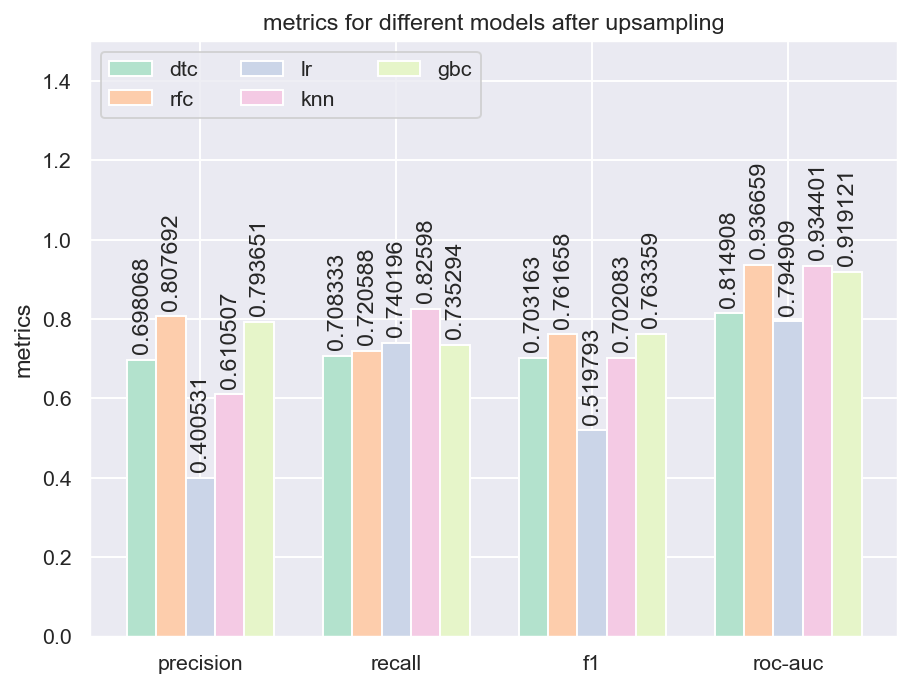

In [381]:
cmap = sns.color_palette("Pastel2")
metrics = ('precision','recall','f1','roc-auc')
models = {
    'dtc': tuple(resup.values[0]),
    'rfc': tuple(resup.values[1]),
    'lr': tuple(resup.values[2]),
    'knn': tuple(resup.values[3]),
    'gbc': tuple(resup.values[4])
}

x = np.arange(len(metrics))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in models.items():
    sns.color_palette("Pastel2")
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, color=cmap[multiplier])
    ax.bar_label(rects, padding=3, rotation=90)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('metrics')
ax.set_title('metrics for different models after upsampling')
ax.set_xticks(x + width*2, metrics)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 1.5)
plt.show()

Наглядно видно, что 2 самые точные модели - `RandomForestClassifier` и `GradientBoostingClassifier`. У обеих моделей показатели находятся примерно на одном уровне с разницей в сотых. Неожиданно отличися `KNN` при вычислении `recall` - следовательно, можно сделать вывод, что если у нас в задаче необходима максимизация `recall` - то можно будет попробовать `KNN`. В итоге будем сравнивать 2 модели: `RandomForestClassifier` и `GradientBoostingClassifier`.

# Тестирование модели:

In [382]:
res_fin = pd.DataFrame(index=['dummy','constant','gbc','rfc'], columns=['precision','recall','f1','roc-auc'])

Проверим модель на адекватность - сравним её с константной моделью и с Dummy-предсказателем:

In [383]:
dummy_regr = DummyRegressor(strategy="median").fit(features_train_upsampled, target_train_upsampled)
res_fin.loc['dummy','precision'] = precision_score(target_test, dummy_regr.predict(features_test))
res_fin.loc['dummy','recall'] = recall_score(target_test, dummy_regr.predict(features_test))
res_fin.loc['dummy','f1'] = f1_score(target_test, dummy_regr.predict(features_test))
res_fin.loc['dummy','roc-auc'] = roc_auc_score(target_test, dummy_regr.predict(features_test))


constant_model = pd.Series([0]*len(target_test))
res_fin.loc['constant','precision'] = precision_score(target_test, constant_model)
res_fin.loc['constant','recall'] = recall_score(target_test, constant_model)
res_fin.loc['constant','f1'] = f1_score(target_test, constant_model)
res_fin.loc['constant','roc-auc'] = roc_auc_score(target_test, constant_model)

res_fin.loc['gbc','precision'] = precision_score(target_test, model_gbcup.predict(features_test))
res_fin.loc['gbc','recall'] = recall_score(target_test, model_gbcup.predict(features_test))
res_fin.loc['gbc','f1'] = f1_score(target_test, model_gbcup.predict(features_test))
res_fin.loc['gbc','roc-auc'] = roc_auc_score(target_test, model_gbcup.predict_proba(features_test)[:,1])

res_fin.loc['rfc','precision'] = precision_score(target_test, model_rfcup.predict(features_test))
res_fin.loc['rfc','recall'] = recall_score(target_test, model_rfcup.predict(features_test))
res_fin.loc['rfc','f1'] = f1_score(target_test, model_rfcup.predict(features_test))
res_fin.loc['rfc','roc-auc'] = roc_auc_score(target_test, model_rfcup.predict_proba(features_test)[:,1])

res_fin.sort_values('f1',ascending=False)

,precision,recall,f1,roc-auc
gbc,0.632385,0.56778,0.598344,0.839068
rfc,0.641509,0.534381,0.583065,0.856569
dummy,0.2036,1.0,0.338318,0.5
constant,0.0,0.0,0.0,0.5


AUC-ROC: 0.8390675525128304


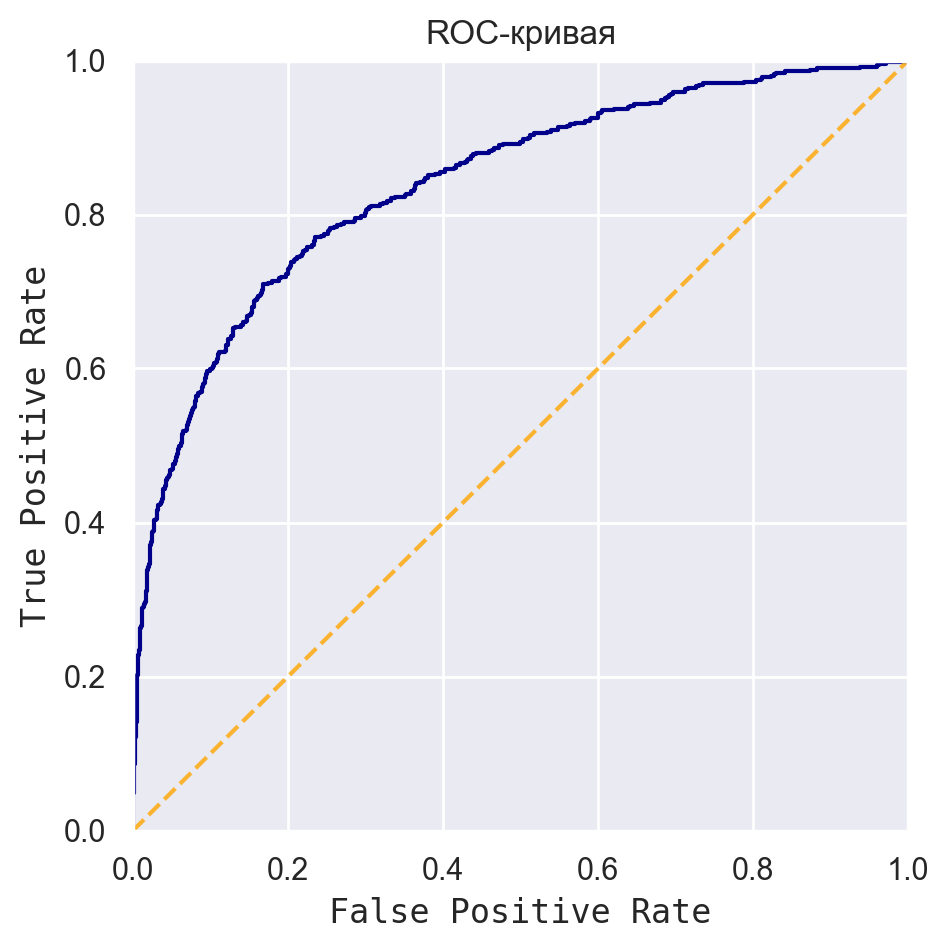

In [386]:
ftt(model_gbcup, features_test, target_test)

Несмотря на то, что RandomForestClassifier определяет классы немного лучше (`roc-auc-rfc` = 0.856 > `roc-auc-gbc` = 0.839), оцениваем мы по `f1`, поэтому остановимся на `GradientBoostingClassifier` 

Показатели финальной модели лучше, чем и у константной модели, и у dummy-классификатора, следовательно, проверка на адекватность модели успешно пройдена, F1 меры > 0.59 мы также добились.

In [390]:
res_fin.sort_values('f1',ascending=False)

,precision,recall,f1,roc-auc
gbc,0.632385,0.56778,0.598344,0.839068
rfc,0.641509,0.534381,0.583065,0.856569
dummy,0.2036,1.0,0.338318,0.5
constant,0.0,0.0,0.0,0.5


# Выводы

В первоначальных данных наблюдался значительный дисбаланс (80% ответов целевого признака были негативными и только 20% позитивными), из-за чего обученные на этих данных модели не проходили проверку на адекватность.

На первоначальных данных все модели показали достаточно низкие результаты вычислений полноты, точности и других метрик качества, после устранения дисбаланса классов техникой upsampling все модели показали результат выше, чем на несбалансированной выборке. Лучшие показатели были у модели `GradientBoosting(lr=0.1, max_depth=10, n_estimators=100)`:

- Полнота: 0.56778; 
- Точность: 0.632385;
- f1-мера: 0.598344

Финальная модель прошла проверку на адекватность в сравнении с контантной моделью: 

- f1 константной модели: 0.0
- f1 dummy-модели: 0.33818
- f1 gbc: 0.598344

- AUC-ROC константой модели: 0.5
- AUC-ROC dummy-модели: 0.5
- AUC-ROC gbc: 0.839068